# LSTM (Long Short-Term Memory) w PyTorch

## Co to jest LSTM?

LSTM (Long Short-Term Memory) to specjalny typ rekurencyjnej sieci neuronowej (RNN), który został zaprojektowany do rozwiązania problemu zanikającego gradientu w tradycyjnych RNN.

### Główne problemy RNN:
- **Zanikający gradient** - trudność w uczeniu się długoterminowych zależności
- **Eksplodujący gradient** - niestabilność podczas treningu

### Jak LSTM rozwiązuje te problemy:
LSTM wprowadza specjalną strukturę nazywaną **komórką pamięci** (cell state) oraz trzy **bramy** (gates):

1. **Brama zapomnienia** (Forget Gate) - decyduje, które informacje usunąć z komórki pamięci
2. **Brama wejścia** (Input Gate) - decyduje, które nowe informacje zapisać w komórce pamięci
3. **Brama wyjścia** (Output Gate) - decyduje, które części komórki pamięci wysłać jako wyjście

## Zastosowania LSTM:
- Przetwarzanie języka naturalnego (NLP)
- Prognozowanie szeregów czasowych
- Rozpoznawanie mowy
- Tłumaczenie maszynowe
- Analiza sentymentu

## Import bibliotek

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

## Przykład 1: Podstawowa struktura LSTM w PyTorch

In [8]:
# Podstawowe parametry LSTM
input_size = 1      # liczba cech wejściowych
hidden_size = 50    # liczba neuronów w warstwie ukrytej
num_layers = 2      # liczba warstw LSTM
output_size = 1     # liczba wyjść
sequence_length = 10 # długość sekwencji

# Tworzenie warstwy LSTM
lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

print(f"Warstwa LSTM: {lstm}")
print(f"Liczba parametrów: {sum(p.numel() for p in lstm.parameters())}")

Warstwa LSTM: LSTM(1, 50, num_layers=2, batch_first=True)
Liczba parametrów: 31000


## Przykład 2: Prosty model LSTM do predykcji szeregów czasowych

In [9]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Warstwa LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Warstwa liniowa na wyjściu
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Inicjalizacja stanów ukrytych
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # Forward pass przez LSTM
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Wykorzystujemy tylko ostatnie wyjście
        out = self.linear(out[:, -1, :])
        return out

# Tworzenie modelu
model = SimpleLSTM()
print(model)

SimpleLSTM(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


## Przykład 3: Generowanie danych testowych (funkcja sinus)

Kształt danych: (1000, 50)


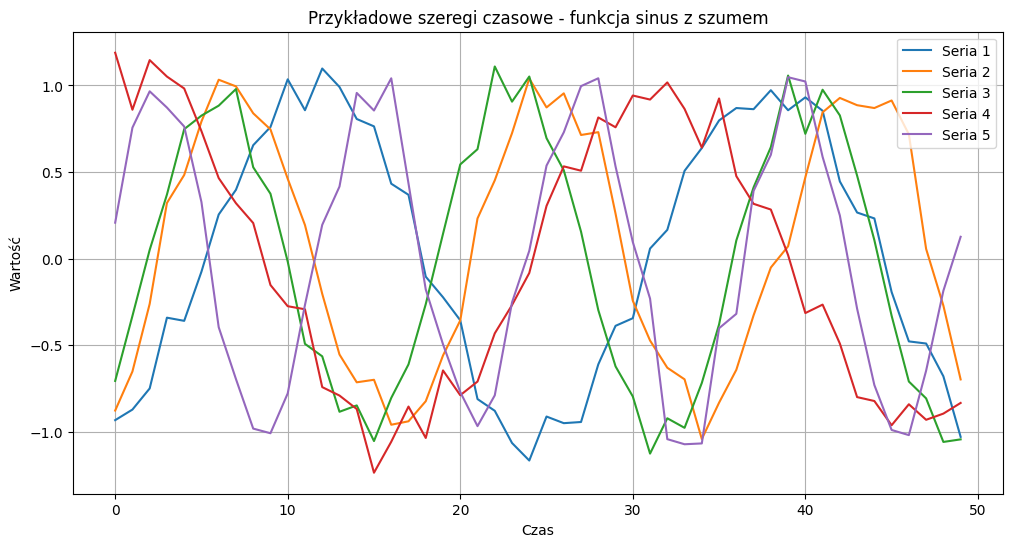

In [10]:
# Generowanie danych - funkcja sinus z szumem
def generate_sine_data(seq_length=100, num_samples=1000):
    x = np.linspace(0, 4*np.pi, seq_length)
    data = []
    
    for i in range(num_samples):
        # Dodajemy losowe przesunięcie fazowe i częstotliwość
        freq = np.random.uniform(0.5, 2.0)
        phase = np.random.uniform(0, 2*np.pi)
        noise = np.random.normal(0, 0.1, seq_length)
        
        y = np.sin(freq * x + phase) + noise
        data.append(y)
    
    return np.array(data)

# Generowanie danych
data = generate_sine_data(seq_length=50, num_samples=1000)
print(f"Kształt danych: {data.shape}")

# Wizualizacja kilku przykładów
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.plot(data[i], label=f'Seria {i+1}')
plt.title('Przykładowe szeregi czasowe - funkcja sinus z szumem')
plt.xlabel('Czas')
plt.ylabel('Wartość')
plt.legend()
plt.grid(True)
plt.show()

## Przykład 4: Przygotowanie danych do treningu

In [11]:
def create_sequences(data, seq_length=10):
    """
    Tworzy sekwencje danych do treningu LSTM
    """
    X, y = [], []
    
    for sample in data:
        for i in range(len(sample) - seq_length):
            # Sekwencja wejściowa
            seq_x = sample[i:(i + seq_length)]
            # Wartość do predykcji
            seq_y = sample[i + seq_length]
            
            X.append(seq_x)
            y.append(seq_y)
    
    return np.array(X), np.array(y)

# Tworzenie sekwencji
sequence_length = 10
X, y = create_sequences(data, sequence_length)

print(f"Kształt X: {X.shape}")
print(f"Kształt y: {y.shape}")

# Normalizacja danych
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X.reshape(-1, 1)).reshape(X.shape)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Podział na zbiory treningowy i testowy
split_idx = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

# Konwersja do tensorów PyTorch
X_train_tensor = torch.FloatTensor(X_train).unsqueeze(-1)  # dodajemy wymiar cech
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test).unsqueeze(-1)
y_test_tensor = torch.FloatTensor(y_test)

print(f"Kształt tensora treningowego X: {X_train_tensor.shape}")
print(f"Kształt tensora treningowego y: {y_train_tensor.shape}")

Kształt X: (40000, 10)
Kształt y: (40000,)
Kształt tensora treningowego X: torch.Size([32000, 10, 1])
Kształt tensora treningowego y: torch.Size([32000])


## Przykład 5: Trening modelu LSTM

In [12]:
# Tworzenie modelu
model = SimpleLSTM(input_size=1, hidden_size=50, num_layers=2, output_size=1)

# Definicja funkcji straty i optymalizatora
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Parametry treningu
num_epochs = 100
batch_size = 32

# Lista do przechowywania strat
train_losses = []

# Trening
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    num_batches = 0
    
    # Mini-batch training
    for i in range(0, len(X_train_tensor), batch_size):
        # Pobieranie batch'a
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        
        # Zerowanie gradientów
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

print("Trening zakończony!")

Epoch [20/100], Loss: 0.0026
Epoch [40/100], Loss: 0.0025
Epoch [60/100], Loss: 0.0024
Epoch [80/100], Loss: 0.0024
Epoch [100/100], Loss: 0.0024
Trening zakończony!


## Przykład 6: Ewaluacja modelu

In [ ]:
# Wizualizacja strat podczas treningu
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.title('Strata podczas treningu')
plt.xlabel('Epoka')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()

# Ewaluacja na zbiorze testowym
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor).squeeze()
    test_loss = criterion(test_predictions, y_test_tensor)
    print(f'Test Loss: {test_loss:.4f}')

# Denormalizacja predykcji
test_predictions_denorm = scaler_y.inverse_transform(test_predictions.numpy().reshape(-1, 1)).flatten()
y_test_denorm = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Wizualizacja predykcji vs rzeczywiste wartości
plt.figure(figsize=(15, 6))

# Pokazujemy tylko pierwsze 200 punktów dla czytelności
n_show = 200
plt.plot(y_test_denorm[:n_show], label='Rzeczywiste wartości', alpha=0.7)
plt.plot(test_predictions_denorm[:n_show], label='Predykcje LSTM', alpha=0.7)
plt.title('Porównanie predykcji LSTM z rzeczywistymi wartościami')
plt.xlabel('Indeks próbki')
plt.ylabel('Wartość')
plt.legend()
plt.grid(True)
plt.show()

# Obliczanie metryk
mse = np.mean((test_predictions_denorm - y_test_denorm) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(test_predictions_denorm - y_test_denorm))

print(f"\nMetryki ewaluacji:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

## Przykład 7: Predykcja nowych wartości

In [ ]:
def predict_next_values(model, sequence, scaler_X, scaler_y, n_future=10):
    """
    Predykcja kolejnych n wartości na podstawie danej sekwencji
    """
    model.eval()
    predictions = []
    
    # Normalizacja wejściowej sekwencji
    current_seq = scaler_X.transform(sequence.reshape(-1, 1)).flatten()
    
    with torch.no_grad():
        for _ in range(n_future):
            # Konwersja do tensora
            seq_tensor = torch.FloatTensor(current_seq).unsqueeze(0).unsqueeze(-1)
            
            # Predykcja
            pred = model(seq_tensor).item()
            predictions.append(pred)
            
            # Aktualizacja sekwencji (usuwamy pierwszy element, dodajemy predykcję)
            current_seq = np.append(current_seq[1:], pred)
    
    # Denormalizacja predykcji
    predictions_denorm = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    
    return predictions_denorm

# Przykład predykcji
# Weźmy ostatnią sekwencję z danych testowych
last_sequence = X_test[-1]  # przed normalizacją
next_values = predict_next_values(model, last_sequence, scaler_X, scaler_y, n_future=20)

# Wizualizacja
plt.figure(figsize=(12, 6))
plt.plot(range(len(last_sequence)), last_sequence, 'b-', label='Historia', linewidth=2)
plt.plot(range(len(last_sequence), len(last_sequence) + len(next_values)), 
         next_values, 'r--', label='Predykcje', linewidth=2)
plt.title('Predykcja przyszłych wartości na podstawie historii')
plt.xlabel('Indeks czasu')
plt.ylabel('Wartość')
plt.legend()
plt.grid(True)
plt.show()

print("Predykcje kolejnych 20 wartości:")
print(next_values)

## Podsumowanie

W tym notatniku poznaliśmy:

### 1. Podstawy LSTM:
- Co to jest LSTM i dlaczego jest lepsze od zwykłych RNN
- Struktura komórek LSTM (bramy zapomnienia, wejścia i wyjścia)
- Zastosowania LSTM

### 2. Implementacja w PyTorch:
- Tworzenie warstwy LSTM
- Budowa kompletnego modelu z LSTM
- Przygotowanie danych sekwencyjnych

### 3. Praktyczny przykład:
- Generowanie danych testowych (funkcja sinus)
- Trening modelu LSTM
- Ewaluacja i wizualizacja wyników
- Predykcja przyszłych wartości

### Następne kroki:
- Eksperymentuj z różnymi architekturami (więcej warstw, różne rozmiary)
- Wypróbuj inne typy danych sekwencyjnych
- Poznaj warianty LSTM: GRU, Bidirectional LSTM
- Zastosuj LSTM do zadań NLP (analiza sentymentu, klasyfikacja tekstu)

### Przydatne parametry do eksperymentowania:
- `hidden_size`: rozmiar warstwy ukrytej
- `num_layers`: liczba warstw LSTM
- `sequence_length`: długość sekwencji wejściowej
- `learning_rate`: tempo uczenia
- `batch_size`: rozmiar batcha